## Protein-Protein Binding Affinity Prediction using Random Forest Regressor

##### Beryl Ramadhian Aribowo 
##### DDP - Master, Kanazawa University

https://github.com/berylgithub

In [9]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

import pickle
import os

In [10]:
'''Dataset Loader'''
def dataset_loader(filepath):
    data = []
    try:
        with open(filepath, 'rb') as fr:
            try:
                while True:
                    data.append(pickle.load(fr))
            except EOFError:
                pass            
    except FileNotFoundError:
        print('File is not found')
    saved_ids = [d['id'] for d in data]
    return data

dataset = dataset_loader('dataset.pkl')

features = np.array([data['x_vector'] for data in dataset])
labels = np.array([data['y'] for data in dataset])
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=13)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1787, 81)
Training Labels Shape: (1787,)
Testing Features Shape: (596, 81)
Testing Labels Shape: (596,)


In [11]:
'''Model Loader'''
with open(os.getcwd()+"/Model/rf_pp_alpha.pkl", "rb") as f:
    rf = pickle.load(f)

In [12]:
'''Model evaluation on training set'''
#Mean Absolute Error
preds = rf.predict(x_train)
errors = abs(preds - y_train)
print('Mean Absolute Error:', round(np.mean(errors), 2))

#Mean Absolute Percentage Error & Accuracy
mape = 100 * (errors / y_train)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_train, preds))
print('Root Mean Squared Error :', round(rmse, 2))

#Pearson Correlation Coefficient (PCC) score
pcc = pearsonr(y_train, preds)
print('Pearson Correlation Coefficient :', round(pcc[0],2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Absolute Error: 0.52
Accuracy: 91.78 %.
Root Mean Squared Error : 0.66
Pearson Correlation Coefficient : 0.98


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


No handles with labels found to put in legend.


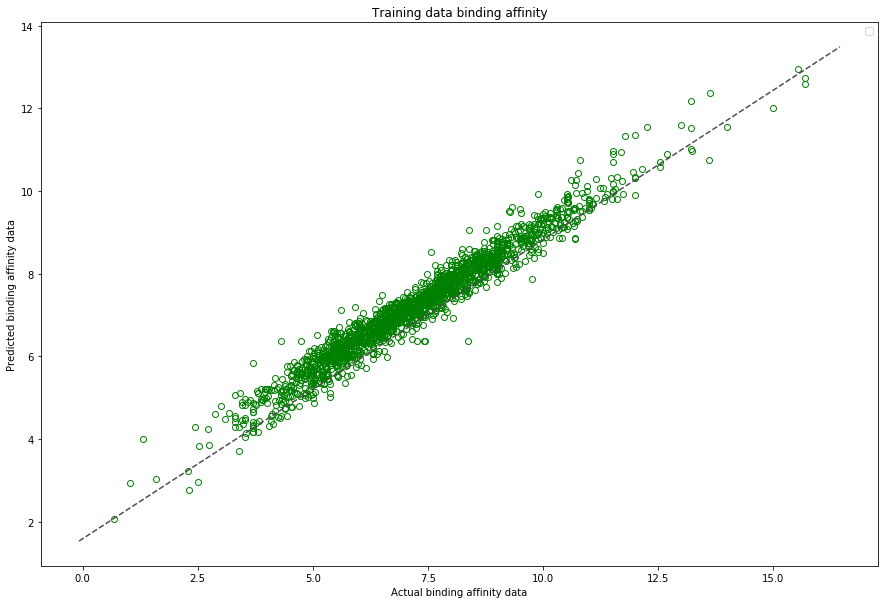

In [14]:
'''Visualization on training set'''
import matplotlib.pyplot as plt

fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

f, ax = plt.subplots()

plt.plot(y_train, preds, 'o', markerfacecolor="None", markeredgecolor='green', markeredgewidth=1)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.title("Training data binding affinity")
plt.xlabel('Actual binding affinity data')
plt.ylabel('Predicted binding affinity data')
plt.legend()
plt.show()

In [15]:
'''Model evaluation on Test set'''
#Mean Absolute Error
preds = rf.predict(x_test)
errors = abs(preds - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))

#Mean Absolute Percentage Error & Accuracy
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, preds))
print('Root Mean Squared Error :', round(rmse, 2))

#Pearson Correlation Coefficient (PCC) score
pcc = pearsonr(y_test, preds)
print('Pearson Correlation Coefficient :', round(pcc[0],2))

Mean Absolute Error: 1.44
Accuracy: 77.98 %.
Root Mean Squared Error : 1.81
Pearson Correlation Coefficient : 0.41


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


No handles with labels found to put in legend.


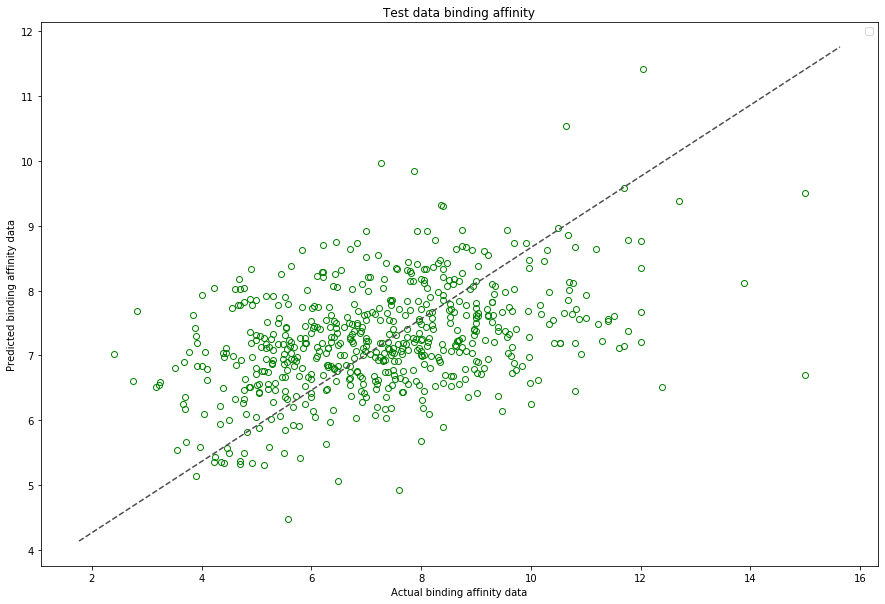

In [16]:
'''Visualization on test set'''
import matplotlib.pyplot as plt

fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

f, ax = plt.subplots()

plt.plot(y_test, preds, 'o', markerfacecolor="None", markeredgecolor='green', markeredgewidth=1)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.title("Test data binding affinity")
plt.xlabel('Actual binding affinity data')
plt.ylabel('Predicted binding affinity data')
plt.legend()
plt.show()


Feature ranking:
1. feature 20 (0.084600)
2. feature 0 (0.073942)
3. feature 46 (0.070475)
4. feature 18 (0.067702)
5. feature 11 (0.066345)
6. feature 14 (0.065647)
7. feature 5 (0.065233)
8. feature 45 (0.062899)
9. feature 19 (0.062567)
10. feature 2 (0.060362)
11. feature 10 (0.057175)
12. feature 47 (0.056491)
13. feature 9 (0.054644)
14. feature 23 (0.052585)
15. feature 1 (0.051979)
16. feature 50 (0.047328)
17. feature 37 (0.000006)
18. feature 40 (0.000003)
19. feature 4 (0.000003)
20. feature 36 (0.000003)
21. feature 49 (0.000003)
22. feature 22 (0.000003)
23. feature 38 (0.000003)
24. feature 13 (0.000001)
25. feature 71 (0.000000)
26. feature 70 (0.000000)
27. feature 69 (0.000000)
28. feature 21 (0.000000)
29. feature 62 (0.000000)
30. feature 16 (0.000000)
31. feature 68 (0.000000)
32. feature 24 (0.000000)
33. feature 25 (0.000000)
34. feature 26 (0.000000)
35. feature 27 (0.000000)
36. feature 17 (0.000000)
37. feature 72 (0.000000)
38. feature 15 (0.000000)
39. featur

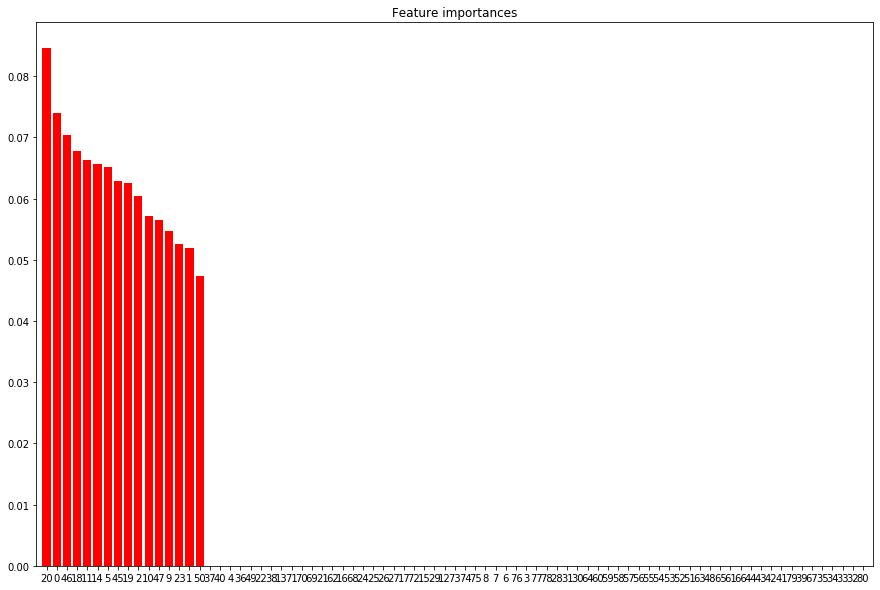

In [17]:
importance = rf.feature_importances_

indices = np.argsort(importance)[::-1]

print("Feature ranking:")
for f in range(importance.shape[0]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(importance.shape[0]), importance[indices],
       color="r", align="center")
plt.xticks(range(importance.shape[0]), indices)
plt.xlim([-1, importance.shape[0]])
plt.show()